# Instacart: Prediction Explorer
This notebook constructs a visualization utility to inspect the model predictions for particular users and model variants.

## Load Data

In [1]:
import pandas as pd
import numpy as np
pd.options.display.latex.repr=True

In [2]:
!ls ../input/instacart-market-basket-analysis/

aisles.csv	 order_products__prior.csv  orders.csv	  sample_submission.csv
departments.csv  order_products__train.csv  products.csv


In [3]:
file_path = '../input/instacart-market-basket-analysis/'

load_data_dtype = {
    'order_id': np.uint32,
    'user_id': np.uint32,
    'eval_set': 'category',
    'order_number': np.uint8,
    'order_dow': np.uint8,
    'order_hour_of_day': np.uint8,
    # pandas 'gotcha'; leave as float:
    'days_since_prior_order': np.float16,
    'product_id': np.uint16,
    'add_to_cart_order': np.uint8,
    'reordered': np.bool
}

df_aisles = pd.read_csv(file_path + 'aisles.csv')
df_departments = pd.read_csv(file_path + 'departments.csv')
df_products = pd.read_csv(file_path + 'products.csv')

# Specify dtype to reduce memory utilization
df_order_products_prior = pd.read_csv(file_path + 'order_products__prior.csv',
                                      dtype=load_data_dtype)
df_order_products_train = pd.read_csv(file_path + 'order_products__train.csv',
                                      dtype=load_data_dtype)
df_orders = pd.read_csv(file_path + 'orders.csv', dtype=load_data_dtype)

# df_prior = full products from all prior orders
df_prior = pd.merge(df_orders[df_orders['eval_set'] == 'prior'],
                    df_order_products_prior,
                    on='order_id')

# # Useful DataFrame for aisle and department feature construction
# df_ad = pd.merge(df_prior, df_products, how='left',
#                  on='product_id').drop('product_name', axis=1)

In [4]:
# Mapping type between product_id and product_name
s_products = (df_products[['product_id', 'product_name']]
              .set_index('product_id')
              .iloc[:,0])

In [5]:
!ls ../input/instacart-top-n-random-forest-model/

N_threshold-N_05-kaggle.csv		 p_kaggle-0.194-test.csv
N_threshold-N_05-test.csv		 p_kaggle-0.194-train.csv
N_threshold-N_05-train.csv		 p_kaggle-0.196-kaggle.csv
N_threshold-N_basket-kaggle.csv		 p_kaggle-0.196-test.csv
N_threshold-N_basket-test.csv		 p_kaggle-0.196-train.csv
N_threshold-N_basket-train.csv		 p_kaggle-0.198-kaggle.csv
N_threshold-N_basket_reorder-kaggle.csv  p_kaggle-0.198-test.csv
N_threshold-N_basket_reorder-test.csv	 p_kaggle-0.198-train.csv
N_threshold-N_basket_reorder-train.csv	 top_N-12-kaggle.csv
N_threshold-N_skew-kaggle.csv		 top_N-12-test.csv
N_threshold-N_skew-test.csv		 top_N-12-train.csv
N_threshold-N_skew-train.csv		 top_N-16-kaggle.csv
N_u-N_u-kaggle.csv			 top_N-16-test.csv
N_u-N_u-test.csv			 top_N-16-train.csv
N_u-N_u-train.csv			 top_N-20-kaggle.csv
N_u-N_u_reorder-kaggle.csv		 top_N-20-test.csv
N_u-N_u_reorder-test.csv		 top_N-20-train.csv
N_u-N_u_reorder-train.csv		 top_N-24-kaggle.csv
__notebook__.ipynb			 top_N-24-test.csv
__output__.json				 top_

In [6]:
file_path = '../input/instacart-top-n-random-forest-model/'

In [7]:
# Build dictionary of model predictions of form
# pred_dict[model_group][model_variant][ds]

import glob
from collections import defaultdict

mydict = lambda: defaultdict(mydict)
pred_dict = mydict()

# Rightmost split after '/' to remove path and
# remove last four characters '.csv'.
# Split each name on '-' into a list of three terms
# [model_group, model_variant, ds]
filenames = [path.rsplit('/')[-1][:-4].split('-')
             for path in glob.glob(file_path + '*.csv')]
# [Alternatively, transpose as array for clarity]
filenames_transposed = [list(phrase) for phrase in zip(*filenames)]

for term in zip(*filenames_transposed):
    pred_dict[term[0]][term[1]][term[2]] = pd.read_csv(file_path
                           + term[0] + '-'
                           + term[1] + '-' 
                           + term[2] + '.csv', 
                            index_col=['user_id', 'product_id'])

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
!ls ../input/instacart-feature-engineering/

__notebook__.ipynb  __output__.json  __results__.html  custom.css  io.h5


In [9]:
# Open X for user lists and y for true orders

store = pd.HDFStore('../input/instacart-feature-engineering/io.h5', 'r')
store.open()

dsets = ['train', 'test', 'kaggle']

X = {ds : store['/X/' + str(ds)] for ds in dsets}
y = {ds : store['/y/' + str(ds)] for ds in dsets}

store.close()

Opening ../input/instacart-feature-engineering/io.h5 in read-only mode


In [10]:
# List of users in each dset
users = {ds : list(X[ds].index.get_level_values('user_id').drop_duplicates()) for ds in dsets}

In [11]:
# Split DataFrames
prior = dict.fromkeys(dsets)
orders = dict.fromkeys(dsets)
orders_full = dict.fromkeys(dsets)

# ad = dict.fromkeys(dsets)

for ds in dsets:
    prior[ds] = df_prior[df_prior['user_id'].isin(users[ds])]
    orders[ds] = df_orders[df_orders['user_id'].isin(users[ds])
                           & (df_orders.eval_set == 'prior')]
    orders_full[ds] = df_orders[df_orders['user_id'].isin(users[ds])]
#     ad[ds] = df_ad[df_ad['user_id'].isin(users[ds])]

In [12]:
del X

## Construct DataFrame of Prior, Ultimate, and Predicted Baskets

Given a model and a user to inspect, this section's functions build a DataFrame with rows `'order_number'` for prior orders, predicted and true baskets as the first two rows, and `'add_to_cart_order'` as column.

In [13]:
def prior_user_orders(user, ds='test'):
    """ Given prior DataFrame and user_id (in 'test'), return DataFrame
    with prior orders (descending order)."""

    prior_user_orders_df = (prior['test'][prior['test']['user_id'] == user]
                            [['order_number', 'add_to_cart_order', 'product_id']]
                            .pivot(index='add_to_cart_order',
                                   columns='order_number',
                                   values='product_id')
                            .fillna(0)
                            .astype('int64'))
    
    return prior_user_orders_df[prior_user_orders_df.columns[-1::-1]]

In [14]:
def true_user_order(user, ds='test'):
    """ Given user_id (in 'test'), return DataFrame of 
    'product_id's of user's true order."""
    
    true_user_order_df = (y[ds]
            .loc[user][y[ds].loc[user][0]]
            .reset_index()
            .drop(0, axis=1))
    
    true_user_order_df.index += 1
    
    return true_user_order_df

In [15]:
def pred_user_order(user, y_pred, ds='test'):
    """ Given user_id (in 'test'), return DataFrame of 
    'product_id's of user's predicted order."""
    
    pred_user_order_df = (y_pred
            .loc[user][y_pred.loc[user]]
            .dropna()              
            .reset_index()
            .drop('0', axis=1))
    
    pred_user_order_df.index += 1
    
    return pred_user_order_df

In [16]:
def combine_prior_ultimate(pred, true, prior):
    """Concatenate and transpose true, predict, and prior
    product order DataFrames."""
    
    combined_df = (pd.concat([pred, true, prior],
                             axis=1)
                   .fillna('')
                   .transpose())

    combined_df.index.name = prior.columns.name
    combined_df.columns.name = prior.index.name
    
    return combined_df

In [17]:
# Colors in order [TP, FP, FN, TN, empty]
default_colors = ['lawngreen',
                 'gold',
                 'deepskyblue',
                 'lightgrey',
                 'none']

def confusion_colors(combined_df,
                     css_attr='',
                     colors=default_colors):
    """Given a DataFrame as returned by combine_prior_ultimate,
    return a color mask for products in true, prediction, 
    overlap, neither, and empty with css style."""
    
    empty_mask = (combined_df.mask(combined_df == '', True) == True)
    
    true_products = list(filter(bool, list(combined_df.loc['true'])))
    true_mask = combined_df.isin(true_products)
    
    pred_products = list(filter(bool, list(combined_df.loc['prediction'])))    
    pred_mask = combined_df.isin(pred_products)    
    
    both_mask = true_mask & pred_mask
    neither_mask = ~ (true_mask | pred_mask) 
    
    color_mask = (both_mask * (css_attr + colors[0])
                  + (pred_mask & (~true_mask)) * (css_attr + colors[1])
                  + (true_mask & (~pred_mask)) * (css_attr + colors[2])
                  + (neither_mask & (~empty_mask)) * (css_attr + colors[3]) 
                  + (empty_mask) * (css_attr + colors[4]))
    
    return color_mask

In [18]:
def build_orders(user, y_pred, ds='test'):
    """For user and y_pred vector, convert true, predicted,
    and prior order product_ids to product_names and concatenate
    into a single DataFrame."""

    # Convert true product_ids to product_names and store as df
    true_user_order_df = pd.DataFrame(true_user_order(user, ds=ds)
                                      .iloc[:,0] #pd 0.24: .to_series
                                      .map(s_products)
                                      .rename('true'))

    # Convert pred product_ids to product_names and store as df
    pred_user_order_df = pd.DataFrame(pred_user_order(user, y_pred, ds=ds)
                                      .iloc[:,0] #pd 0.24: .to_series
                                      .map(s_products)
                                      .rename('prediction'))

    # Convert prior product_ids to product_names and store as df
    prior_user_orders_df = prior_user_orders(user, ds=ds)

    for col in prior_user_orders_df:
        prior_user_orders_df[col] = prior_user_orders_df[col].map(s_products)

    # Combine pred, true, prior
    combined_df = combine_prior_ultimate(
        pred_user_order_df,
        true_user_order_df,
        prior_user_orders_df)
    
    return combined_df

Note: .replace() is tidier but too slow; [.map() is an order of magnitude faster](https://stackoverflow.com/a/41678874).

## Plot

The main plot function and example usage follow.

In [19]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

def plot_orders(ax, user, model, ds='test',
                user_title=True, model_title=True,
                colors=default_colors):
    """Return Axes for plot of a user's order history with predictions
    and true ultimate orders as the first two rows.
    
    Parameters
    ----------
    ax : Axes
        The axes on which to draw

    user : int
        user_id
    
    model : list
        of the form [model_group, model_variant]

    ds : string
        the dset of user_id
    
    user_title : bool
        Display user_id in title
                
    model_title : bool
        Display model_variant in title
        
    colors : list of HTML color strings ordered as
        [TP, FP, FN, TN, empty]
                
    """

    y_pred = pred_dict[model[0]][model[1]][ds]
    
    # Prepare (n, m, 3) array of rgb values
    # from (n, m) array of color strings output from
    # confusion_colors(build_orders())
    color_str_to_rgb = np.vectorize(mcolors.to_rgba)
    rgb_array = np.array(
        color_str_to_rgb(
            confusion_colors(build_orders(user, y_pred))
            .values)
    ).transpose(1, 2, 0)
    
    # Plot rgb_array with various options    
    ax.imshow(rgb_array, aspect='equal')
    ax.autoscale_on=True
    
    # Make title
    title = ''
    if user_title==True:
        title += 'user_id = ' + str(user) + '\n'
    if model_title==True:
        title += model[0] + '-' + model[1]
    ax.set_title(title)

    # Make bounding boxes for true and predicted ultimate order
    ax.axhline(y=-0.5, color='k', linewidth=4)
    ax.axhspan(ymin=-0.5, ymax=0.5, fill=False, linewidth=2)
    ax.axhspan(ymin=0.5, ymax=1.5, fill=False, linewidth=2)

    # Remove ticks and spines
    ax.set_xticks([])
    ax.set_yticks([])

    for key in ax.spines.keys():
        ax.spines[key].set_visible(False)
    
    return ax

### Set Values

Recall the structure of `pred_dict` is a nested dictionary. The top level keys are names of the `model_group`s and the next level keys are names of `model_variant`s:

In [20]:
print(list(pred_dict.keys()))

['N_threshold', 'top_N', 'p_kaggle', 'N_u']


In [21]:
print(list(pred_dict['N_threshold'].keys()))

['N_basket', 'N_skew', 'N_basket_reorder', 'N_05']


In [22]:
# Select a few models as a list of tuples of the
# forms (model_group, model_variant):

models_list = [
    ('N_threshold', 'N_basket'),
    ('N_u', 'N_u'),
    ('top_N', '8'),
    ('top_N', '20')
]

In [23]:
# Choose a list of user_ids (in 'test')

ds = 'test'

user_list = [users[ds][17], users[ds][18], users[ds][19]]

### Display

The default color scheme is:
* $\color{lawngreen}{\text{True Positives: Ordered and Predicted}}$
* $\color{gold}{\text{False Positives: Predicted but not Ordered}}$
* $\color{deepskyblue}{\text{False Negatives: Ordered but not Predicted}}$
* $\color{lightgrey}{\text{True Negatives: neither Ordered nor Predicted}}$

A model with greater **precision** has fewer $\color{gold}{\text{False Positives}}$ while a model with greater **recall** has fewer $\color{deepskyblue}{\text{False Negatives}}$.

Note: `'add_to_cart_order'` is not meaningful for the top rows of predictions and true orders.

Begin with a view of the styled DataFrame for single user's orders for a fixed model:

In [24]:
# Choose the 18th user (in 'test')
# (Why the 18th? Because the 17th is too damn predictable!)
# and the first model in models_list

user = user_list[1]
model_group, model_variant = models_list[0][0], models_list[0][1]

In [25]:
# Display with product_names
(build_orders(user, pred_dict[model_group][model_variant][ds])
 .style
 .apply(confusion_colors, axis=None, css_attr='background-color: '))

add_to_cart_order,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
order_number,,,,,,,,,,,,,,,,,,,,,,
prediction,Hampshire 100% Natural Sour Cream,Cut & Peeled Baby Carrots,Bistro Bowl Chicken Caesar Salad,Salisbury Steak with macaroni and cheese Salisbury Steak with macaroni and cheese,Multi-Grain Club Crackers,Sliced Sourdough Bread,Organic Fat-Free Milk,Blueberry on the Bottom Nonfat Greek Yogurt,Chicken & Apple Smoked Chicken Sausage,French Onion Dip,Coke,Meatloaf and Mashed Potatoes,Butter Toffee Peanuts,Spiced Rum,Strawberry on the Bottom Nonfat Greek Yogurt,Non Fat Black Cherry on the Bottom Greek Yogurt,Poppycock Cashew Lovers,,,,,
true,Chicken Thighs,Cut & Peeled Baby Carrots,Bistro Bowl Chicken Caesar Salad,Deluxe Plain Bagels,Ritz Crackers,Sliced Sourdough Bread,Organic Fat-Free Milk,French Onion Dip,Extra Large Eggs,Coke,Fresh Scent Speed Stick Deodorant,Butter Toffee Peanuts,Spiced Rum,"Red Onions, Fresh Diced",Poppycock Cashew Lovers,,,,,,,
13,Strawberry on the Bottom Nonfat Greek Yogurt,Blueberry on the Bottom Nonfat Greek Yogurt,Non Fat Black Cherry on the Bottom Greek Yogurt,Colagate Total Whitening Toothpaste,Cut & Peeled Baby Carrots,Sliced Sourdough Bread,Poppycock Cashew Lovers,Butter Toffee Peanuts,Leather Wipes,"Honest Face, Hand, & Baby Wipes",Bulgarian Cultured Buttermilk,Ham Steak,Petite-Cut Diced Tomatoes,Unsalted Chicken Stock,Yellow Onions,Chicken & Apple Smoked Chicken Sausage,Spiced Rum,,,,,
12,Cut & Peeled Baby Carrots,French Onion Dip,Sliced Sourdough Bread,Original Cream Cheese,Deluxe Plain Bagels,Ultra Plush® 3 Ply Double Toilet Paper Rolls,Select-a-Size Rolls Paper Towels Tissue,Coke,Hampshire 100% Natural Sour Cream,Bistro Bowl Chicken Caesar Salad,Poppycock Cashew Lovers,Butter Toffee Peanuts,,,,,,,,,,
11,Roma Tomato,French Bread,Organic Navel Orange,Whole Grains Oatnut Bread,Hampshire 100% Natural Sour Cream,Broccoli Crown,Cooking Beef Stock,Horseradish,French Onion Dip,Cut & Peeled Baby Carrots,Ritz Crackers,Meatloaf and Mashed Potatoes,Salisbury Steak with macaroni and cheese Salisbury Steak with macaroni and cheese,Organic Fat-Free Milk,Classic Mix Variety,Fruit Horns,Mini Corn Dogs,Breakfast Claws,,,,
10,Spiced Rum,French Onion Dip,Bistro Bowl Chicken Caesar Salad,Complete Clean Power Toilet Bowl Cleaner Value Pack,Assorted Chocolate Miniatures Chocolate Candy Bars,Multi-Grain Club Crackers,Cut & Peeled Baby Carrots,Classic Mix Variety,Chicken & Apple Smoked Chicken Sausage,Extra Large Eggs,Philadelphia Cream Cheese Spread,Ultra Apple Blossom Antibacterial Dish Liquid,Deluxe Cinnamon Raisin Bagels,Sourdough Cracked Wheat Bread,Mini Corn Dogs,,,,,,,
9,Coke,Spiced Rum,Sliced Sourdough Bread,Cut & Peeled Baby Carrots,French Onion Dip,Rigatoni Pasta,Crackers,Chicken Thighs,Cream of Mushroom Condensed Soup Family Size,Cream Of Celery Condensed Soup,Slider Stand & Fill Storage Gallon Bags,Slider Storage Quart Bags,Cinnamon Horns,Fruit Horns,Original Cream Cheese,Deluxe Plain Bagels,Seedless Red Grapes,Mini Watermelon,Organic Fat-Free Milk,Hampshire 100% Natural Sour Cream,Garlic Bread,Butter
8,Spiced Rum,Butter,Coke,Original Citrus Sparkling Flavored Soda,Meatloaf and Mashed Potatoes,Salisbury Steak with macaroni and cheese Salisbury Steak with macaroni and cheese,360 Dusters Refills Unscented,French Onion Dip,Cut & Peeled Baby Carrots,Sauvignon Blanc,Multi-Grain Club Crackers,Pre-Sliced Black Forest Ham,Baby Swiss Cheese Pre-Sliced Deli,Country White Bread,Sliced Sourdough Bread,,,,,,,
7,Coke,Roasted Salted Almonds,Zingers Cakes,Ultra Apple Blossom Antibacterial Dish Liquid,Spiced Rum,"PODS Laundry Detergent, Original Designed for Regular and HE Washers Laundry",Regular Pork Sausage Tube,Homestyle Meatballs,Diced Tomatoes,Tomato Sauce,Living Herbs Potted Living Basil,Tomato Paste,Rigatoni Pasta,Garlic Bread,Sliced Sourdough Bread,Organic Fat-Free Milk,Fresh Scent Speed Stick Deodorant,Breakfast Claws,Fruit Horns,,,


"Zoom out" by ignoring product names:

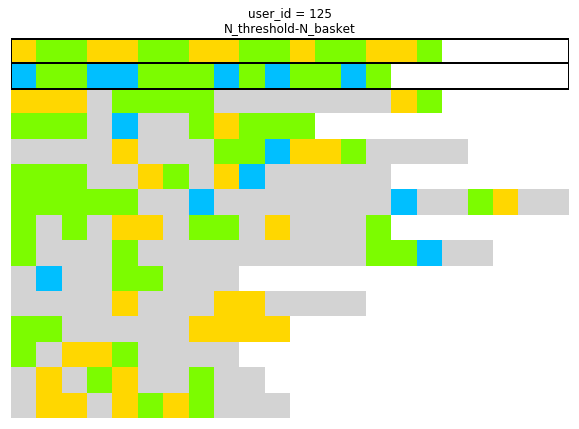

In [26]:
fig, ax = plt.subplots(figsize=(10,10))

ax = plot_orders(ax, user, (model_group, model_variant))

Now "zoom out" further to cover more models and more users:

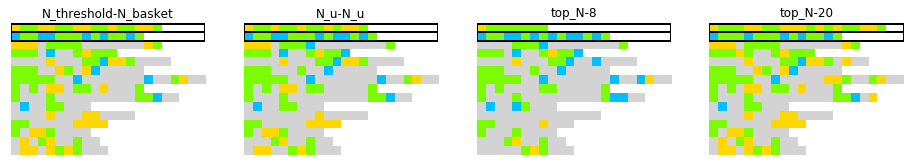

In [27]:
# Iterate over models for given user

fig, axs = plt.subplots(1, len(models_list),
                        sharex=True,
                        figsize=(16,4))

for model in range(len(models_list)):
    axs[model] = plot_orders(axs[model],
                             user,
                             models_list[model],
                             user_title=False)

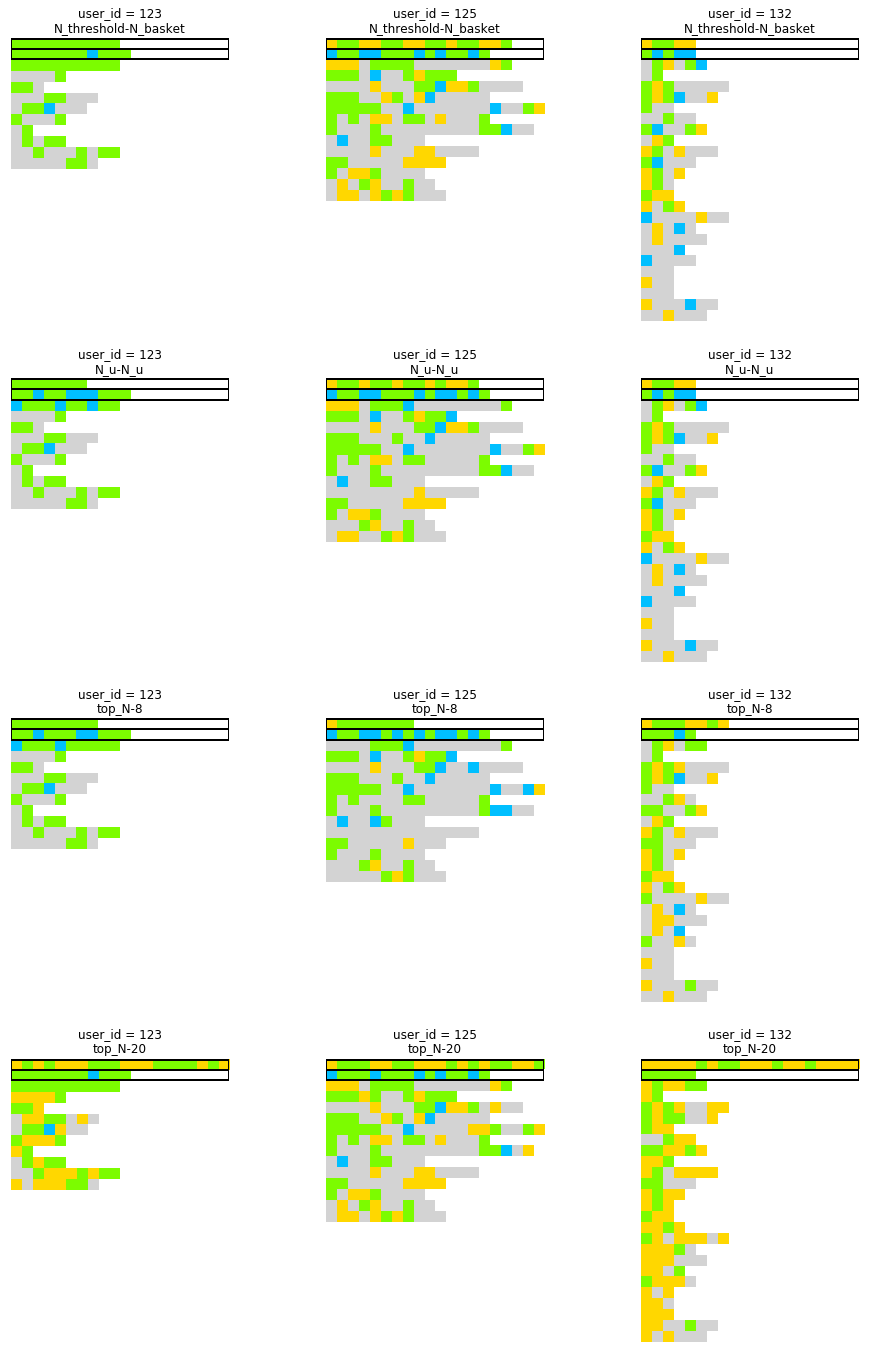

In [28]:
# Iterate over models_list and user_list

import itertools

fig, axs = plt.subplots(len(models_list), len(user_list),
                        sharex=True, sharey=True,
                        figsize=(16,24))

for (row, col) in itertools.product(range(len(models_list)),
                                    range(len(user_list))):

    axs[row, col] = plot_orders(axs[row, col],
                                user_list[col],
                                models_list[row])

 Todo:
* Option to sort columns lexicographically by (isin(set), count()) instead of add_to_cart_order?
* Make plot with mouseover for name and for each product highlight matching products in other orders using Bokeh (or D3.js).